## Images size 

In [ ]:
image_width = 9576
image_height = 6388
print(f"{image_height/2 =}")
print(f"number of pixels: {image_width * image_height:_}")
print(f"original image is 122MB")   

image_height/2 =3194.0
number of pixels: 61_171_488
original image is 122MB


# Goal

The goal of this notebook is to calculate the **beam center** for all the apertures measured (0, 60, 120, 180, 240 and 300)

NB: This notebooks takes **the profile files** produced by the [profile](https://neutronimaging.ornl.gov/tutorials/imaging-notebooks/profile/linear-profile/) notebook.

<img src='../beam_line_alignment/static/screenshot_of_profile_file.png' />


## python import

In [2]:
import os
import pandas as pd
import numpy as np
import lmfit
import glob
import re

from ipywidgets import interactive
from IPython.core.display import HTML
from IPython.display import display

import ipywidgets as widgets

import pprint
from tqdm import tqdm

from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

Define the **base folder (base_folder)** from where all the data set will be located. 

For example, if you are working on the analysis machine:

*top_folder = "/SNS/VENUS/IPTS-31716/shared/2023-06-12-analysis/"


# User input 

fitting model used

In [3]:
mod = lmfit.models.GaussianModel() + lmfit.models.ConstantModel()

In [4]:
top_folder = "/SNS/VENUS/IPTS-35023/shared/processed_data/alignment_study/"    
assert os.path.exists(top_folder)

### set up base folder 

In [5]:
base_folder = top_folder + "/VAS_and_colimator_alignment_w_epis"
assert os.path.exists(base_folder)  # making sure the base folder exists

# Method

In [6]:
def cleaning_list_name_columns(list_name_columns):
    clean_list_name_columns = []
    for _index_column, _line in enumerate(list_name_columns):
        _line_no_space = _line.replace(" ", "")
        file_name, col_name = _line_no_space.split("->")
        # various_part_of_file_name = file_name.split("/")
        # clean_list_name_columns.append(various_part_of_file_name[-1])
        clean_list_name_columns.append(file_name[2:])
    return clean_list_name_columns

# let's display the profiles
def plot_profiles(original_data_dict, file_name, title=""):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_title(title)
    ax.set_xlabel("pixels")
    ax.set_ylabel("Counts")
    for _key in original_data_dict[file_name]['list_profiles'].keys():
        ax.plot(original_data_dict[file_name]['xaxis'],
                original_data_dict[file_name]['list_profiles'][_key],
                label=_key)
    ax.legend()
    plt.show()

# let's display the fitted profiles
def plot_fitted_profiles(original_data_dict, master_profile_fitted_dict, file_name, title=""):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_title(title)
    ax.set_xlabel("pixels")
    ax.set_ylabel("Counts")
    for _key in original_data_dict[file_name]['list_profiles'].keys():
        yaxis = original_data_dict[file_name]['list_profiles'][_key]
        xaxis = original_data_dict[file_name]['xaxis']
        ax.plot(xaxis, yaxis, label=_key)
        ax.plot(xaxis, master_profile_fitted_dict[file_name][_key]['fitting'], label=f"{_key} fitting")
    ax.legend()
    plt.show()

# Loading all the profiles data

The following profiles were used on all the data sets

<img src='../beam_line_alignment/static/vertical_profile.png' />
<img src='../beam_line_alignment/static/horizontal_profile.png' />

### retrieving list of files to load 

In [7]:
list_profile_files = glob.glob(base_folder + '/*.txt')
assert len(list_profile_files)



## load profiles 

In [8]:
# raw_data_dict = {'horizontal_profile.txt': {'profiles': {'0deg_30s_frames_OB_median.tif': [],
#                                                          '0deg_nbr1_30s_frames_OB_median.tif': [],
#                                                          ...},
#                                             'xaxis': []},
#                  'vertical_profile.txt': ...
#                 }

original_data_dict = {}
total_number_of_fitting_step = 0

for _file in list_profile_files:
    
    base_file_name = os.path.basename(_file)
    print(f"retrieving data and metadata from {base_file_name}")
    if base_file_name.startswith("horizontal_profile"):
        mode = 'horizontal'
        x_axis_label = '##x_axis'
    else:
        mode = 'vertical'
        x_axis_label = '##y_axis'
    print(f"mode: {mode}")

    # for each file, retrieve the line starting with #List of files
    number_of_images = 0
    with open(_file, 'r') as f:
        for line in f:
            if line.startswith("#List of files"):
                match = re.match(r"#List of files \((\d*) files\)", line)
                number_of_images = int(match.group(1))
                break
        else:
            continue

    number_of_lines_to_skip = number_of_images + 7

    # read the file with the number of lines to skip
    pd_data = pd.read_csv(_file, skiprows=number_of_lines_to_skip)
    x_axis = pd_data[x_axis_label].values

    metadata = None
    # read the metadata    
    with open(_file, 'r') as f:
        for line in f:
            if line.startswith("# * [x0, y0, x1, y1]"):
                metadata_line = line.strip()
                _, second_part = metadata_line.split(" = ")
                match = re.match(r"\[(\d*), (\d*), (\d*), (\d*)\]", second_part.strip())
                x0, y0, x1, y1 = map(int, match.groups())
                metadata = {'x0': x0, 'y0': y0, 'x1': x1, 'y1': y1}
                break

    if metadata is None:
        raise ValueError(f"Metadata not found in the file {_file}")

    # retrieve list of columns
    pd_metadata = pd.read_csv(_file, skiprows=6, names=["files"], nrows=number_of_images)
    list_names_of_columns = pd_metadata["files"].values
    list_images = cleaning_list_name_columns(list_names_of_columns)
   
    list_columns = pd_data.columns
    colummn_image_ref = {}
    _dict = {}
    for _index, _col_name in enumerate(list_columns[1:]):
        profile = np.asarray(pd_data[_col_name])
        _dict[_col_name[2:]] = profile
        total_number_of_fitting_step += 1
        colummn_image_ref[_col_name[2:]] = list_images[_index]

    original_data_dict[base_file_name] = {'xaxis': x_axis,
                                          'list_profiles': _dict,
                                          'column_image_ref': colummn_image_ref,
                                          'profile': {'x0': metadata['x0'],
                                                      'y0': metadata['y0'],
                                                      'x1': metadata['x1'],
                                                      'y1': metadata['y1']},
    }



retrieving data and metadata from vertical_profile_14.txt
mode: vertical
retrieving data and metadata from horizontal_profile_10.txt
mode: horizontal
retrieving data and metadata from horizontal_profile_11.txt
mode: horizontal
retrieving data and metadata from vertical_profile_11.txt
mode: vertical
retrieving data and metadata from horizontal_profile_14.txt
mode: horizontal
retrieving data and metadata from vertical_profile_15.txt
mode: vertical
retrieving data and metadata from vertical_profile_10.txt
mode: vertical
retrieving data and metadata from horizontal_profile_15.txt
mode: horizontal


In [9]:
original_data_dict

{'vertical_profile_14.txt': {'xaxis': array([1044, 1045, 1046, ..., 5686, 5687, 5688]),
  'list_profiles': {'col.1': array([23966.848, 24031.643, 23983.357, ..., 23237.203, 23250.94 ,
          28276.01 ]),
   'col.2': array([23981.611, 23963.928, 23969.297, ..., 23276.734, 23305.133,
          28261.164]),
   'col.3': array([23996.674, 24023.52 , 23973.316, ..., 23341.56 , 23374.072,
          28454.725]),
   'col.4': array([24008.877, 24054.664, 23989.652, ..., 23298.418, 23249.44 ,
          28240.02 ]),
   'col.5': array([23952.307, 23957.   , 23920.602, ..., 23262.94 , 23342.785,
          28276.307]),
   'col.6': array([23836.398, 23851.98 , 23790.041, ..., 23406.836, 23465.092,
          28133.041])},
  'column_image_ref': {'col.1': '/SNS/VENUS/IPTS-35023/images/zwo/alignment/2025-03-20_VAS_and_colimator_alignment_w_epis/LoverD500/BOAT_ZWO_10s__ThermNeut_VAS500_000_000deg_Slits_fully_open20by20_default_beam.tif',
   'col.2': '/SNS/VENUS/IPTS-35023/images/zwo/alignment/2025-03-20

In [10]:
# list of profiles files loaded
for _file in original_data_dict.keys():
    print(f" * {_file}")

 * vertical_profile_14.txt
 * horizontal_profile_10.txt
 * horizontal_profile_11.txt
 * vertical_profile_11.txt
 * horizontal_profile_14.txt
 * vertical_profile_15.txt
 * vertical_profile_10.txt
 * horizontal_profile_15.txt


In [11]:
# we estimate the center position (initial parameter to the fitting algorithm)
estimated_center = {'horizontal': 4456,    # 4456
                    'vertical': 2912}

# Work with horizontal profile

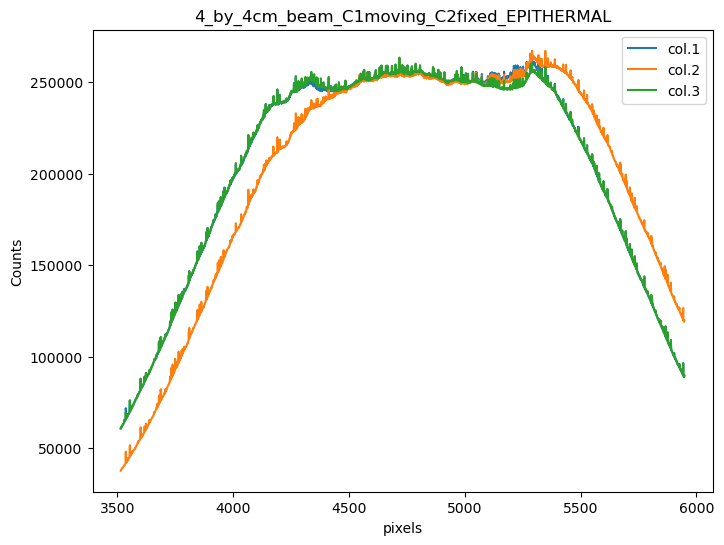

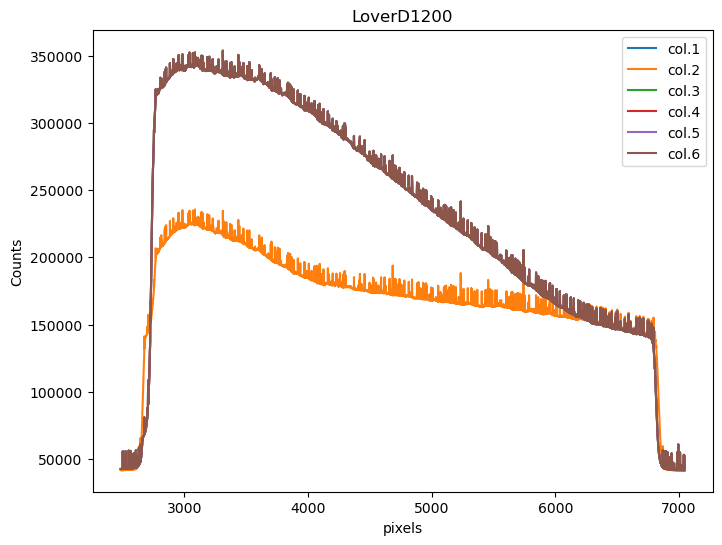

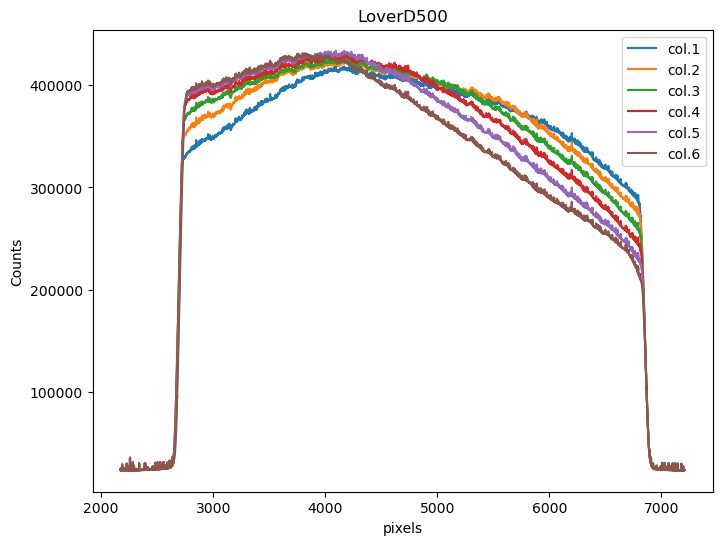

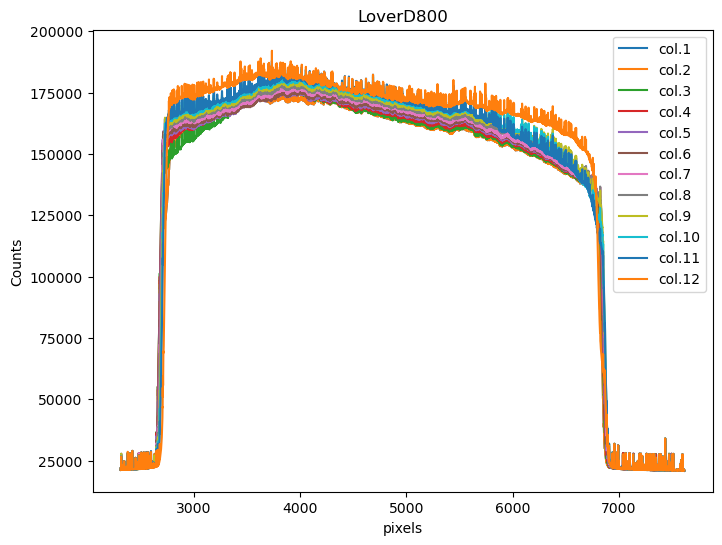

In [12]:
list_keys_sorted = sorted(list(original_data_dict.keys()))
horizontal_list_keys = []
for _file in list_keys_sorted:
    if _file.startswith("horizontal_profile"):
        full_source_file_name = original_data_dict[_file]['column_image_ref']['col.1']
        base_file_name = os.path.basename(os.path.dirname(full_source_file_name))
        horizontal_list_keys.append(_file)
        plot_profiles(original_data_dict, _file, title=base_file_name)


In [13]:
master_horizontal_profile_fitted_dict = {}
for _profile_file_name in tqdm(horizontal_list_keys):
    print(f"working with {_profile_file_name}")
    
    xaxis = original_data_dict[_profile_file_name]['xaxis']  

    profile_dict = {}
    for _index, _key in enumerate(original_data_dict[_profile_file_name]['list_profiles'].keys()):
    
        yaxis = original_data_dict[_profile_file_name]['list_profiles'][_key]

        pars = mod.make_params(c=yaxis.mean(),
                      center=estimated_center['horizontal'],
                      sigma=xaxis.std(),
                      amplitude=xaxis.std() * yaxis.ptp())
        out = mod.fit(yaxis, pars, x=xaxis)

        profile_dict[_key] = {'center_value': round(out.params['center'].value),
                                'center_error': out.params['center'].stderr,
                                'fitting': out.best_fit,
                                }
        
    master_horizontal_profile_fitted_dict[_profile_file_name] = profile_dict

print("Fitting done!")

  0%|          | 0/4 [00:00<?, ?it/s]

working with horizontal_profile_10.txt


 25%|██▌       | 1/4 [00:02<00:06,  2.20s/it]

working with horizontal_profile_11.txt


 50%|█████     | 2/4 [00:03<00:02,  1.48s/it]

working with horizontal_profile_14.txt


 75%|███████▌  | 3/4 [00:09<00:03,  3.47s/it]

working with horizontal_profile_15.txt


100%|██████████| 4/4 [00:21<00:00,  5.25s/it]

Fitting done!


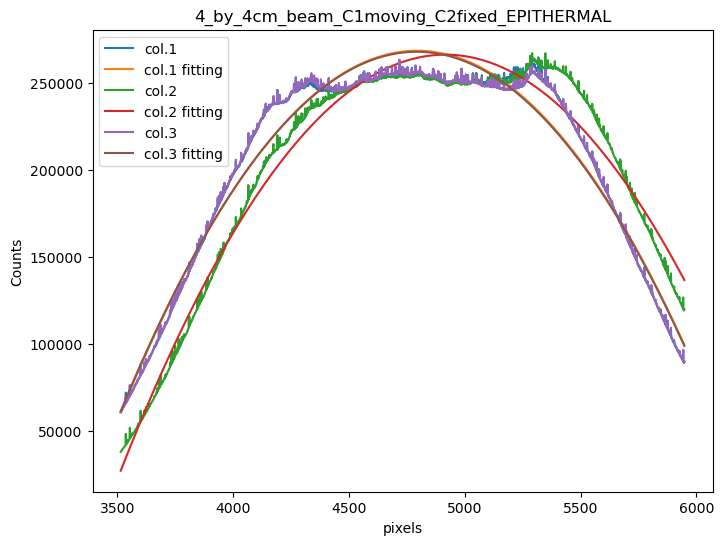

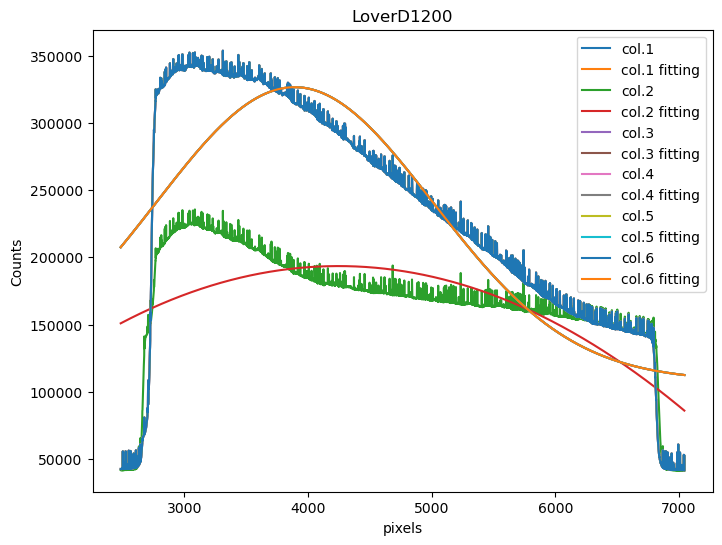

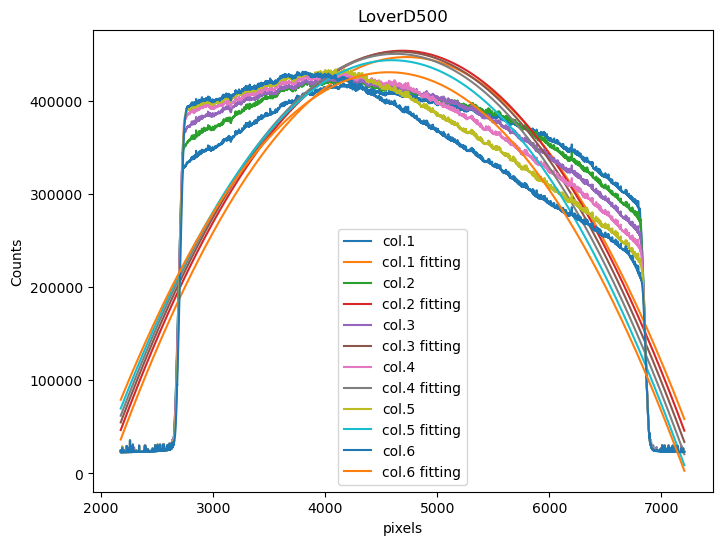

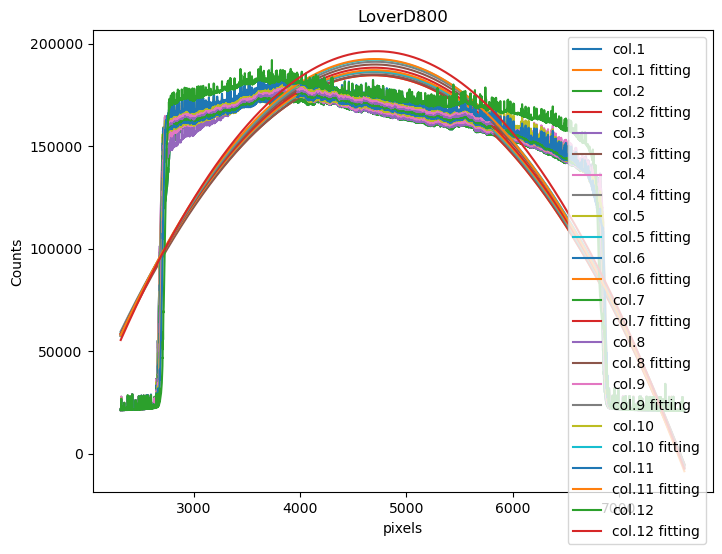

In [14]:
for _file in master_horizontal_profile_fitted_dict.keys():
    full_source_file_name = original_data_dict[_file]['column_image_ref']['col.1']
    base_file_name = os.path.basename(os.path.dirname(full_source_file_name))
    plot_fitted_profiles(original_data_dict, master_horizontal_profile_fitted_dict, _file, title=base_file_name)
    


# work with vertical profile


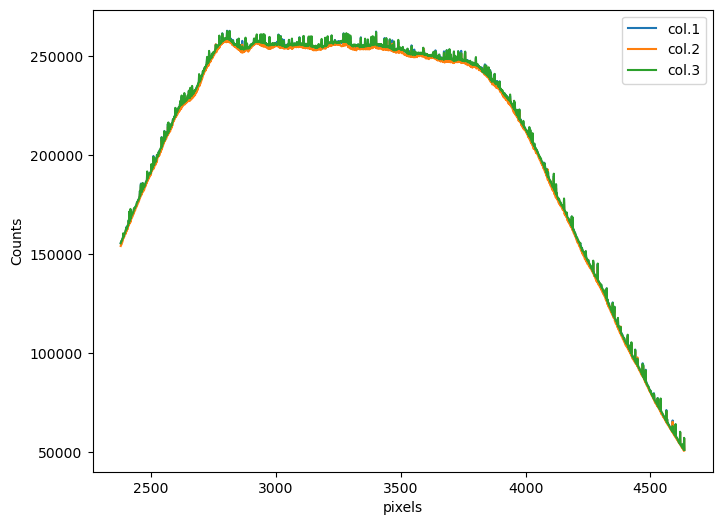

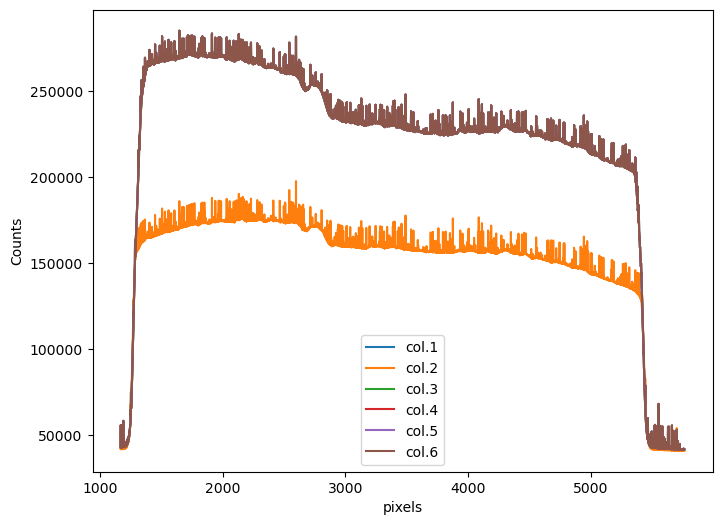

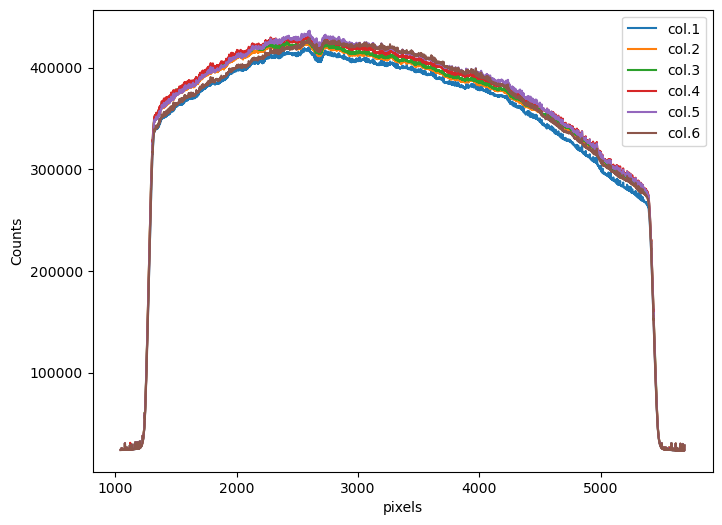

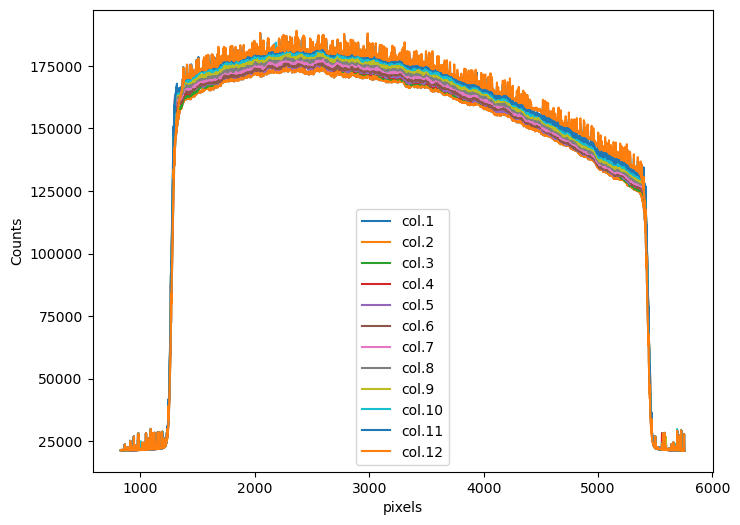

In [15]:
vertical_list_keys = []
for _file in list_keys_sorted:
    if _file.startswith("vertical_profile"):
        vertical_list_keys.append(_file)
        plot_profiles(original_data_dict, _file)

In [16]:
master_vertical_profile_fitted_dict = {}
for _profile_file_name in tqdm(vertical_list_keys):
    print(f"working with {_profile_file_name}")
    
    xaxis = original_data_dict[_profile_file_name]['xaxis']  

    profile_dict = {}
    for _index, _key in enumerate(original_data_dict[_profile_file_name]['list_profiles'].keys()):
    
        yaxis = original_data_dict[_profile_file_name]['list_profiles'][_key]

        pars = mod.make_params(c=yaxis.mean(),
                      center=estimated_center['horizontal'],
                      sigma=xaxis.std(),
                      amplitude=xaxis.std() * yaxis.ptp())
        out = mod.fit(yaxis, pars, x=xaxis)

        profile_dict[_key] = {'center_value': round(out.params['center'].value),
                                'center_error': out.params['center'].stderr,
                                'fitting': out.best_fit,
                                }
        
    master_vertical_profile_fitted_dict[_profile_file_name] = profile_dict

print("Fitting done!")

  0%|          | 0/4 [00:00<?, ?it/s]

working with vertical_profile_10.txt
working with vertical_profile_11.txt


 50%|█████     | 2/4 [00:05<00:05,  2.83s/it]

working with vertical_profile_14.txt


 75%|███████▌  | 3/4 [00:11<00:03,  3.97s/it]

working with vertical_profile_15.txt


100%|██████████| 4/4 [00:22<00:00,  5.69s/it]

Fitting done!


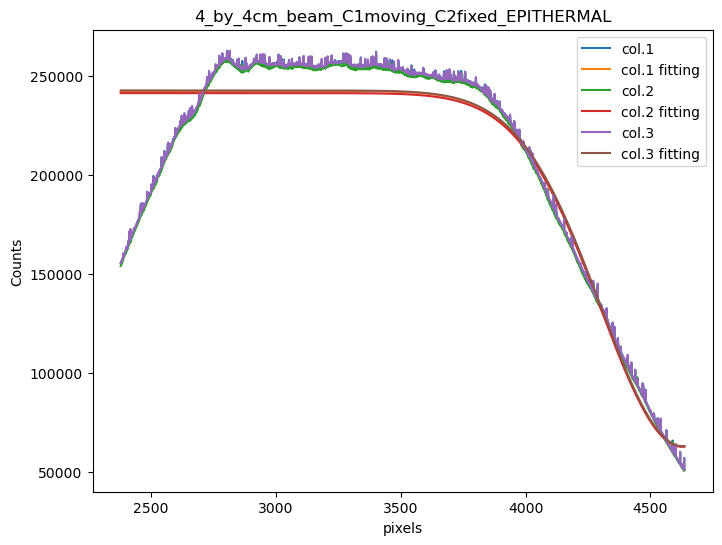

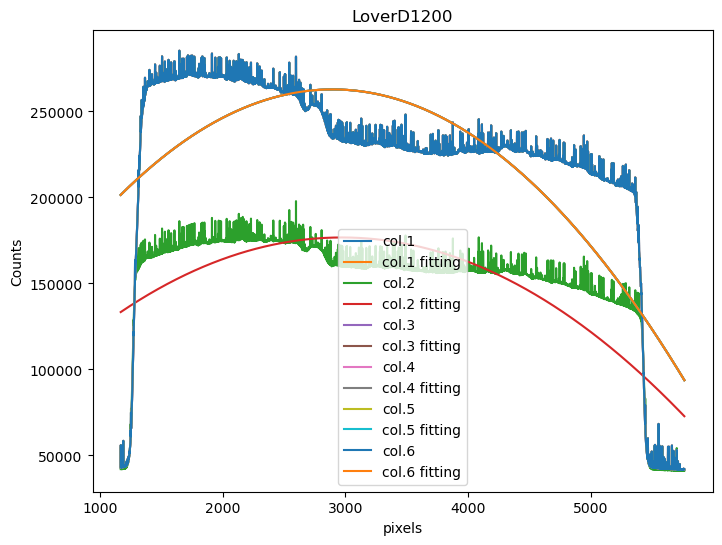

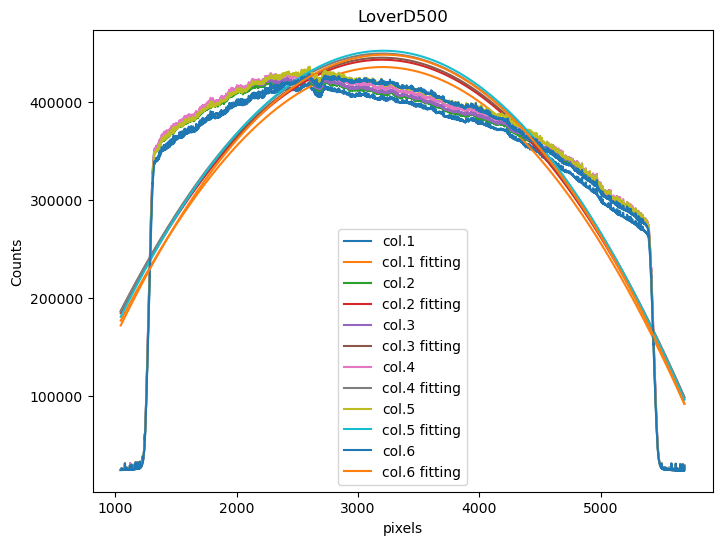

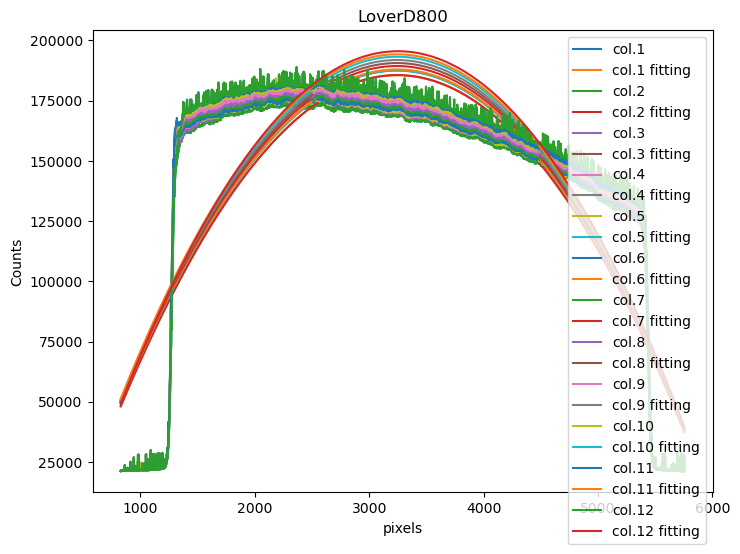

In [17]:
for _file in master_vertical_profile_fitted_dict.keys():
    full_source_file_name = original_data_dict[_file]['column_image_ref']['col.1']
    base_file_name = os.path.basename(os.path.dirname(full_source_file_name))
    plot_fitted_profiles(original_data_dict, master_vertical_profile_fitted_dict, _file, title=base_file_name)

## Loading the images

In [18]:
# let's get the list of images (let's only work with horizontal because vertical uses the same images)
for key in original_data_dict.keys():
    if key.startswith("horizontal_profile"):
        original_data_dict[key]['tiff_data'] = {}
        for key_col in tqdm(original_data_dict[key]['column_image_ref'].keys()):
            _image_path = original_data_dict[key]['column_image_ref'][key_col]
            _image = Image.open(_image_path)
            original_data_dict[key]['tiff_data'][key_col] = np.asarray(_image)


100%|██████████| 12/12 [00:06<00:00,  1.96it/s]


## Let's plot the center of the beam found over the image 

In [19]:
image_size = None

# initialize the dictionary
center_image_dict = {}
for key in original_data_dict.keys():
    _file_index = key.split("_")[-1].split(".")[0]

    center_image_dict[_file_index] = {}

    # list of col / images
    list_column_keys = original_data_dict[key]['column_image_ref'].keys()
    for _key_col in list_column_keys:

        center_image_dict[_file_index][_key_col] = {'x_center': None,
                                                    'y_center': None,
                                                    'image': None,
                                                    'parent_folder_name': None,
                                                    'base_image_name': None}

# let's regroup the infos
for key in original_data_dict.keys():
    if key.startswith("horizontal_profile"):
        _file_index = key.split("_")[-1].split(".")[0]
        list_column_keys = original_data_dict[key]['column_image_ref'].keys()
        for _key_col in list_column_keys:
            _image = original_data_dict[key]['tiff_data'][_key_col]
            center_image_dict[_file_index][_key_col]['image'] = _image

            if image_size is None:
                image_size = _image.shape
            
            center_image_dict[_file_index][_key_col]['parent_folder_name'] = os.path.basename(os.path.dirname(original_data_dict[key]['column_image_ref'][_key_col]))
            center_image_dict[_file_index][_key_col]['base_image_name'] = os.path.basename(original_data_dict[key]['column_image_ref'][_key_col])

# let's regroup the infos
for key in original_data_dict.keys():
    _file_index = key.split("_")[-1].split(".")[0]

    # list of col / images
    list_column_keys = original_data_dict[key]['column_image_ref'].keys()
    for _key_col in list_column_keys:

        # _image = original_data_dict[key]['tiff_data'][_key_col]

        # let's get the center position
        if key.startswith("horizontal_profile"):
            center_x = master_horizontal_profile_fitted_dict[key][_key_col]['center_value']
            center_image_dict[_file_index][_key_col]['x_center'] = center_x
        else:
            center_y = master_vertical_profile_fitted_dict[key][_key_col]['center_value']
            center_image_dict[_file_index][_key_col]['y_center'] = center_y
    



In [20]:
center_image_dict

{'14': {'col.1': {'x_center': 4725,
   'y_center': 3201,
   'image': array([[20162., 20327., 20488., ..., 20389., 20422., 20259.],
          [20162., 20327., 20667., ..., 20488., 20269., 20323.],
          [20378., 20409., 20732., ..., 20444., 20307., 20366.],
          ...,
          [20070., 20269., 20141., ..., 20084., 20164., 20222.],
          [20177., 20092., 20033., ..., 20233., 20038., 20112.],
          [20200., 20474., 20369., ..., 20015., 20038., 20112.]],
         dtype=float32),
   'parent_folder_name': 'LoverD500',
   'base_image_name': 'BOAT_ZWO_10s__ThermNeut_VAS500_000_000deg_Slits_fully_open20by20_default_beam.tif'},
  'col.2': {'x_center': 4689,
   'y_center': 3197,
   'image': array([[20163., 20455., 20388., ..., 20394., 28371., 20446.],
          [20163., 20455., 20436., ..., 20330., 20139., 20316.],
          [20534., 20575., 20415., ..., 20536., 20310., 20298.],
          ...,
          [19838., 20321., 20386., ..., 20339., 20111., 20251.],
          [20032., 203

In [21]:
original_data_dict.keys()

dict_keys(['vertical_profile_14.txt', 'horizontal_profile_10.txt', 'horizontal_profile_11.txt', 'vertical_profile_11.txt', 'horizontal_profile_14.txt', 'vertical_profile_15.txt', 'vertical_profile_10.txt', 'horizontal_profile_15.txt'])

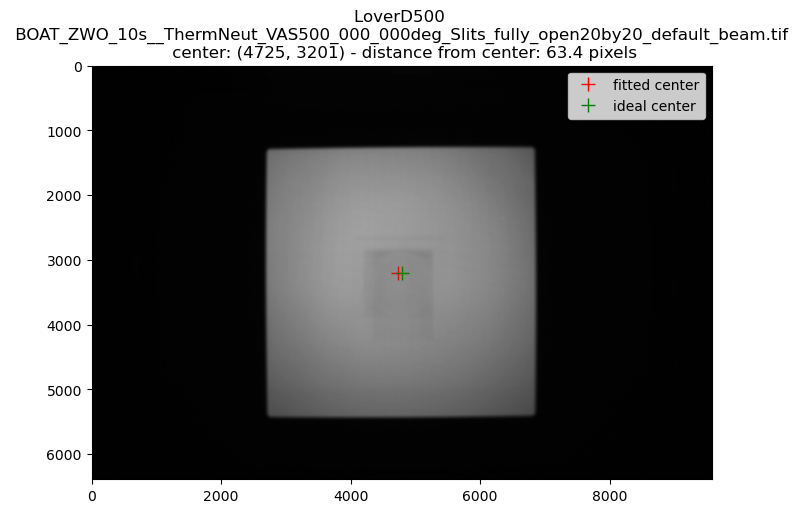

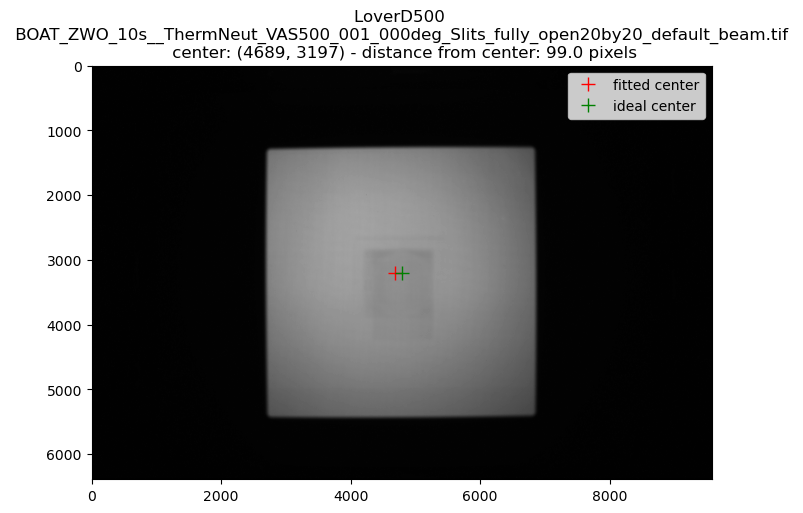

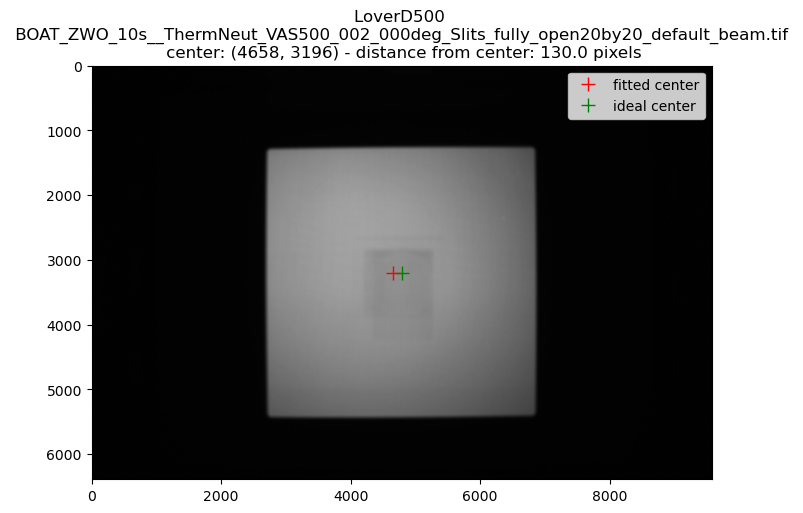

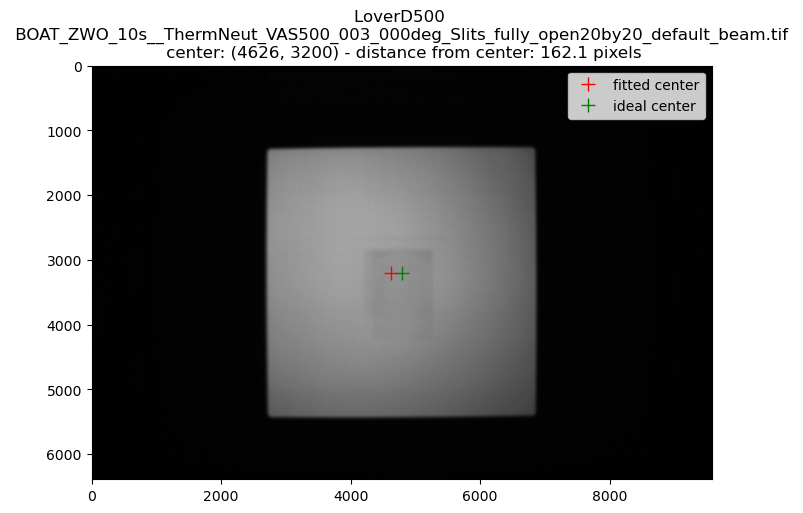

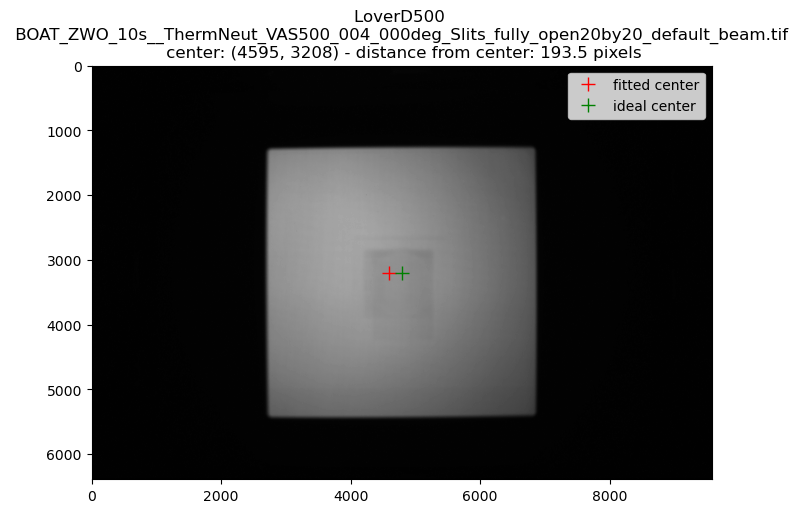

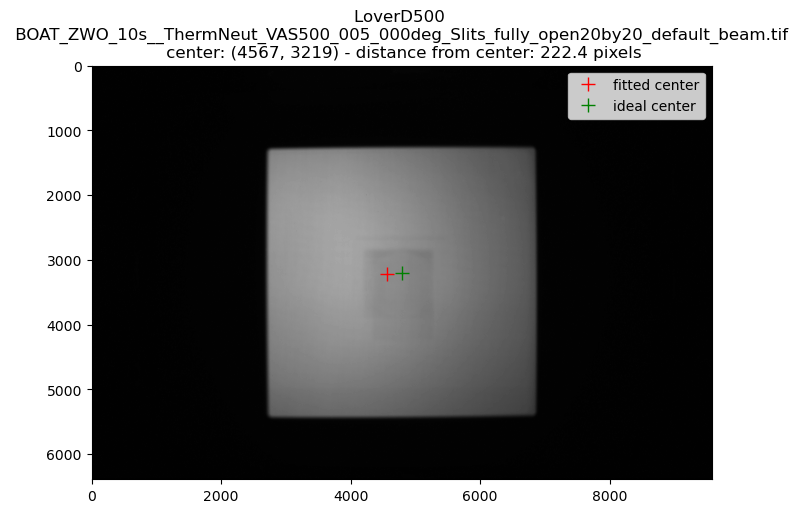

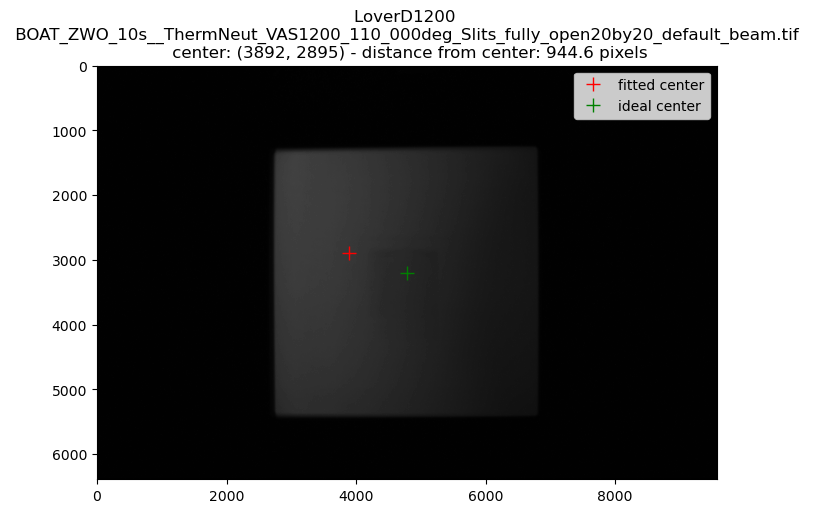

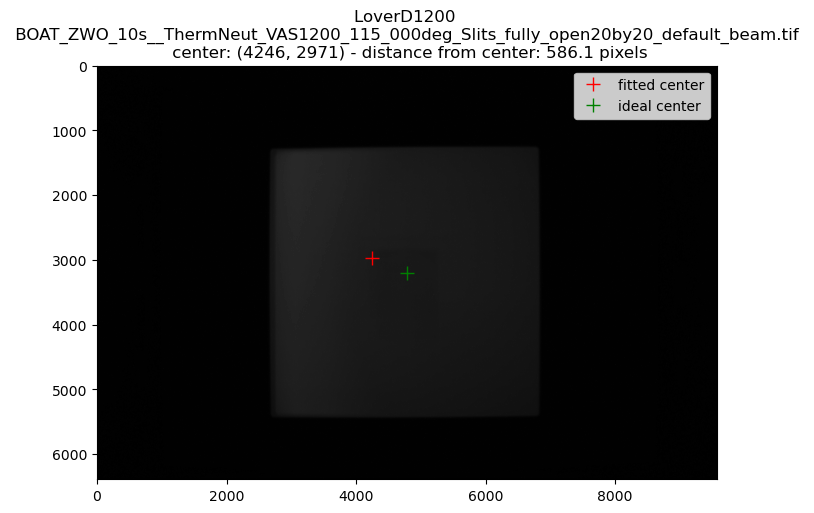

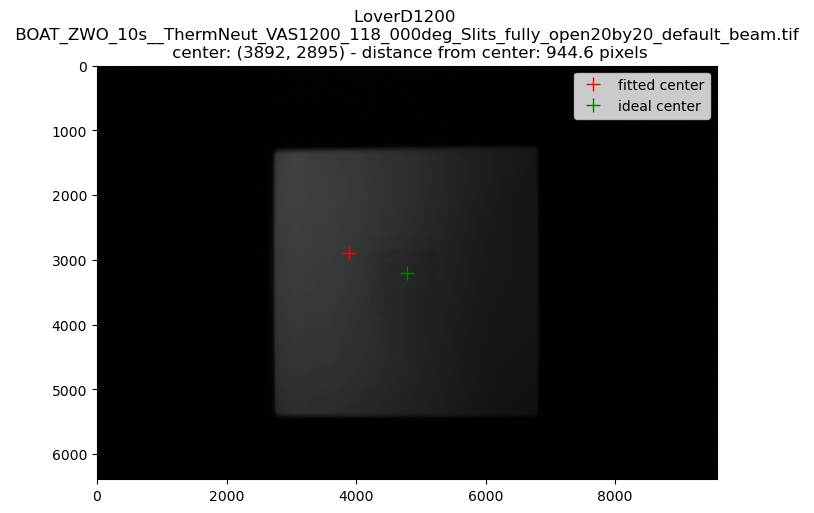

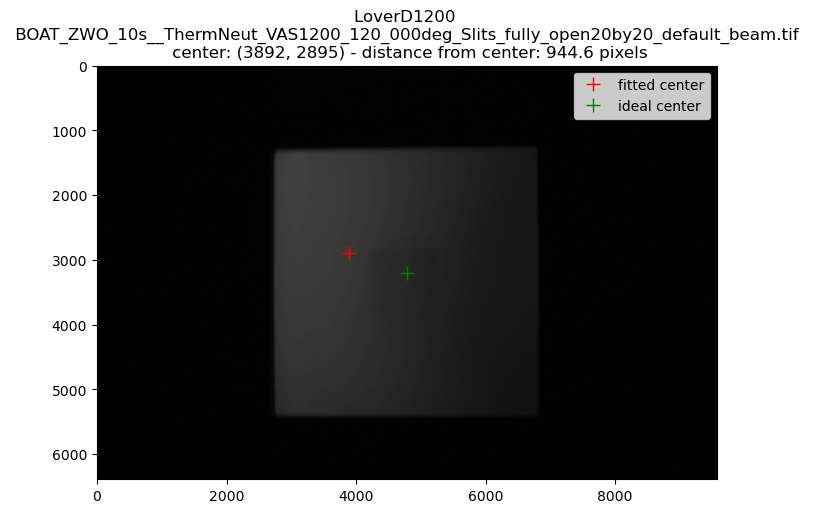

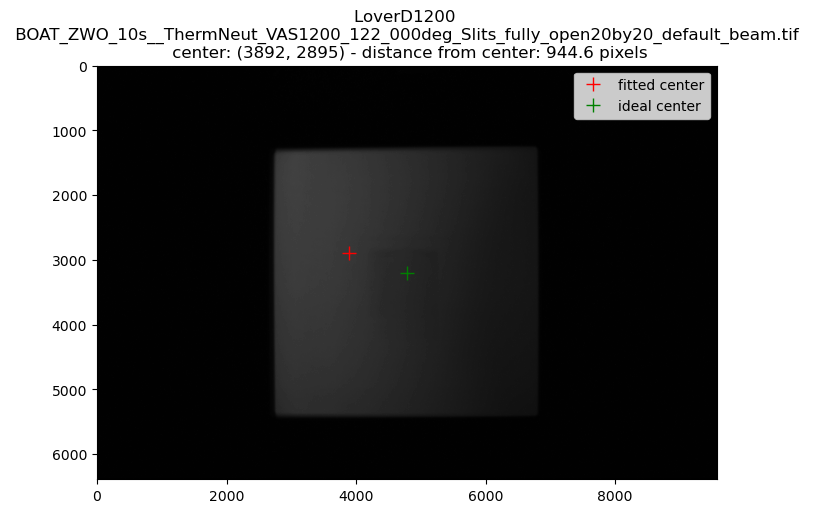

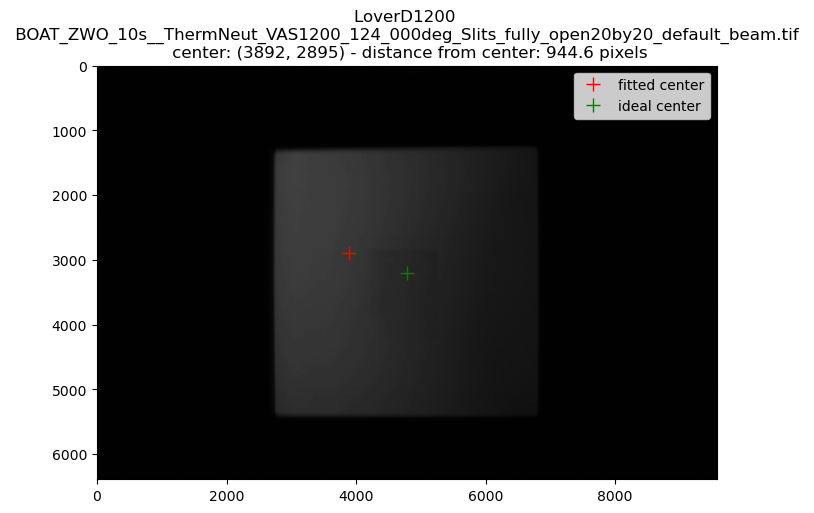

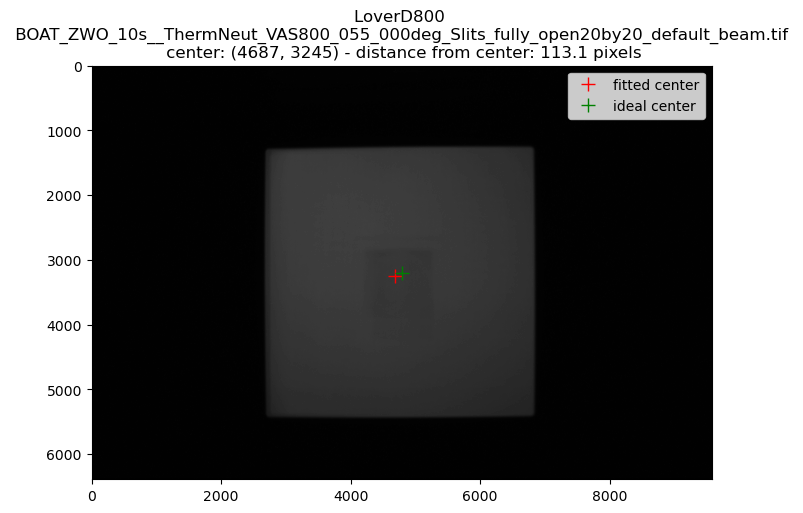

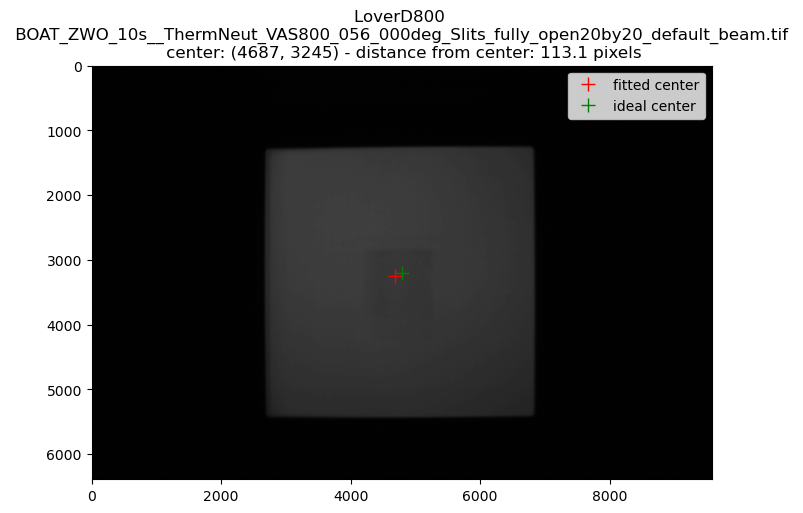

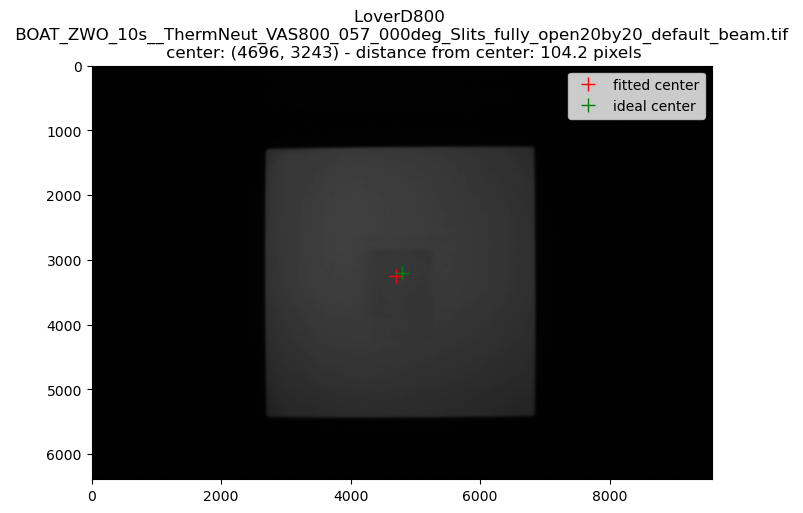

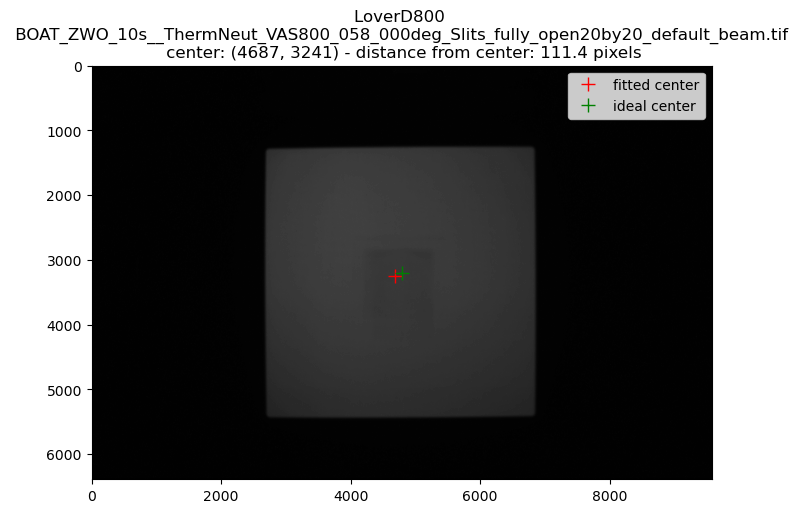

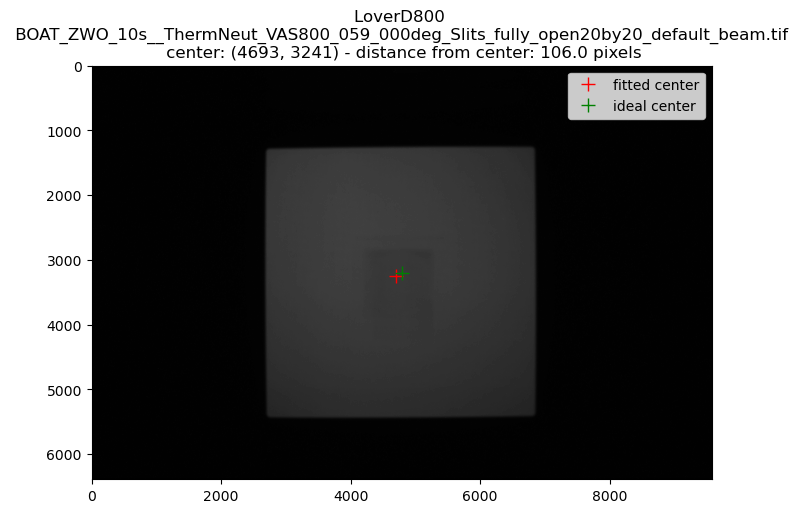

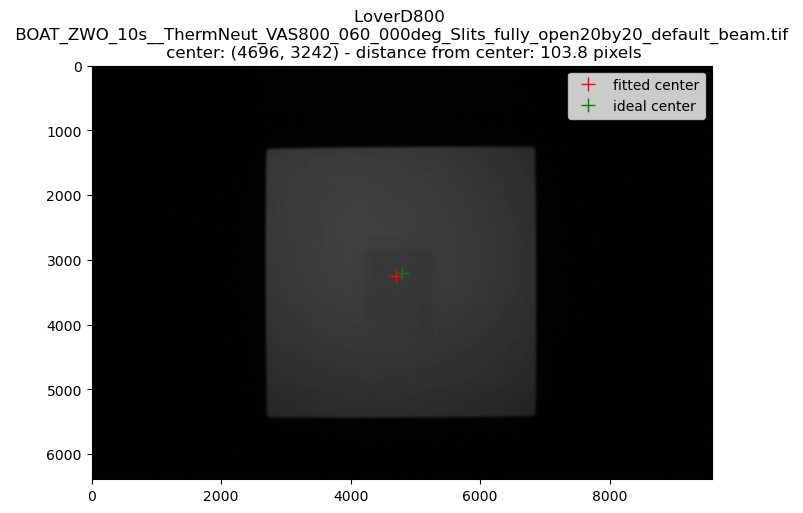

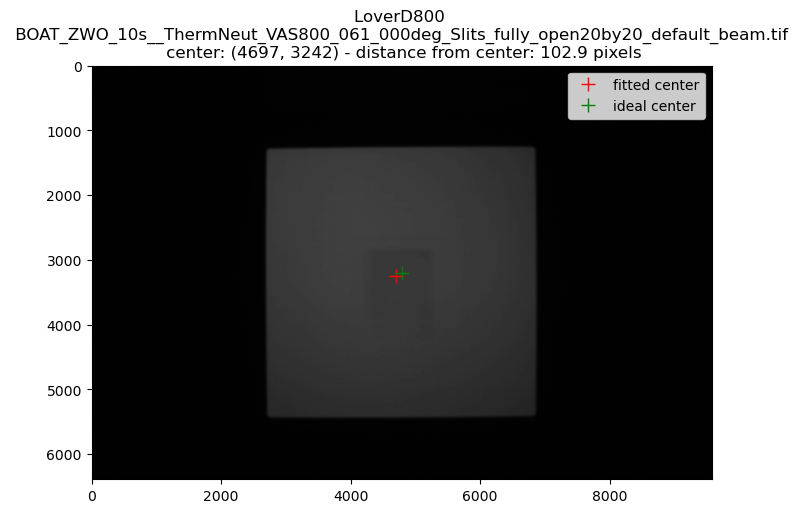

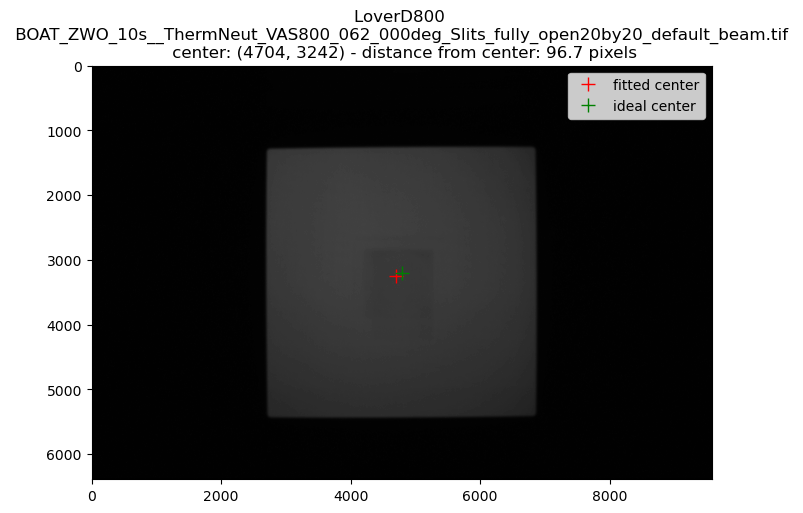

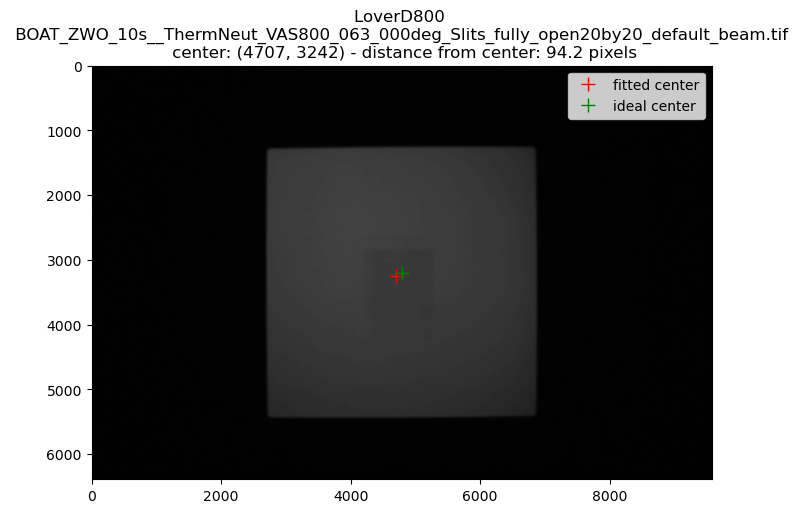

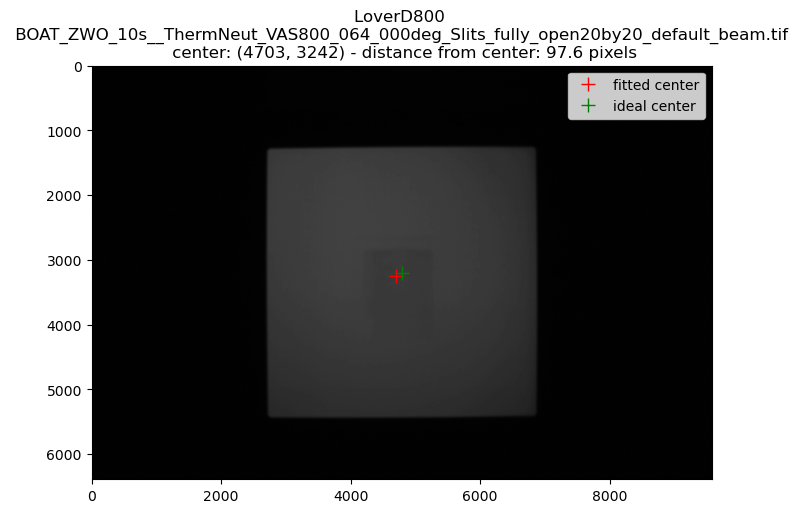

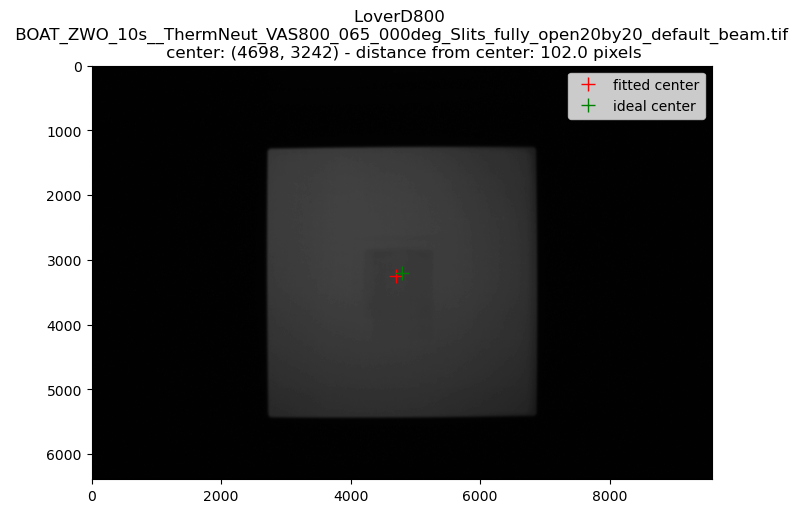

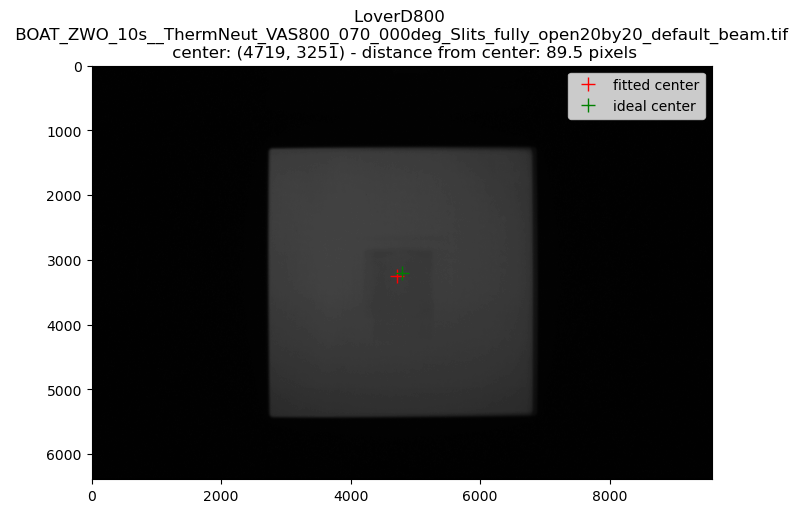

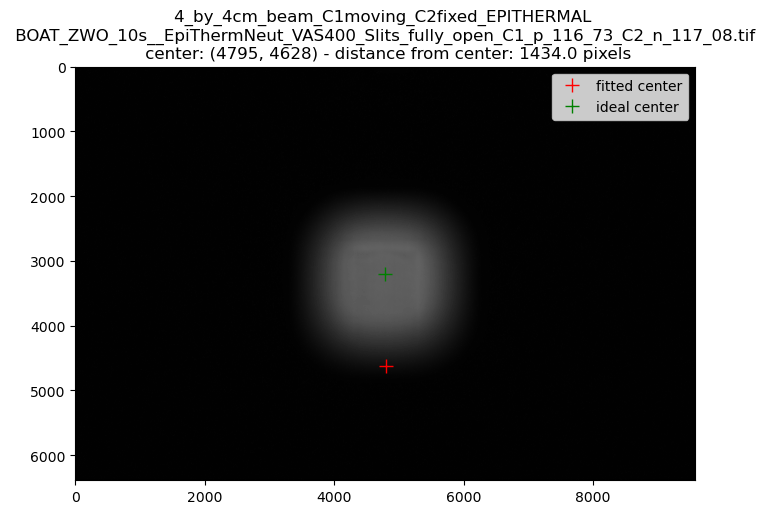

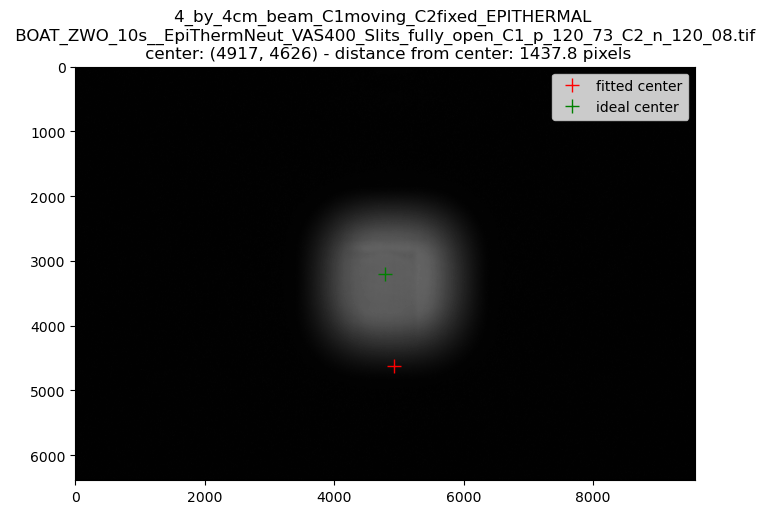

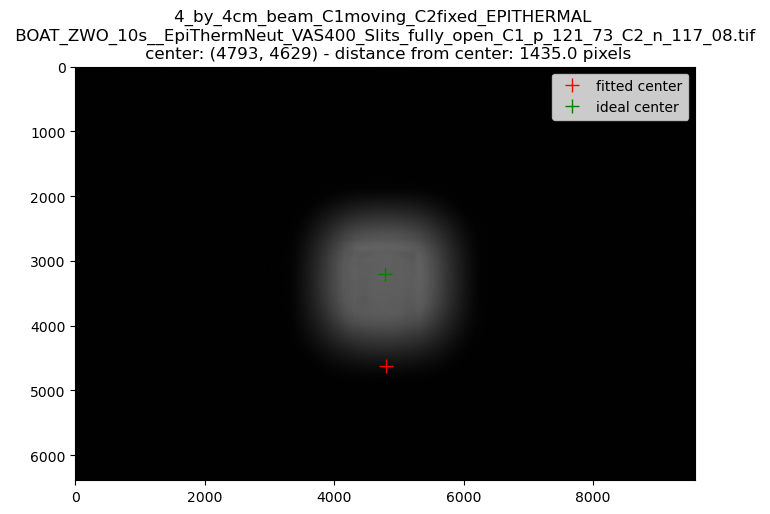

In [22]:

# ideal image center
ideal_center_x = image_size[1] // 2
ideal_center_y = image_size[0] // 2

# let's display the images
for key in original_data_dict.keys():
    if key.startswith("horizontal_profile"):
        continue
    
    _file_index = key.split("_")[-1].split(".")[0]

    # list of col / images
    list_column_keys = original_data_dict[key]['column_image_ref'].keys()
    for _key_col in list_column_keys:
        _image = center_image_dict[_file_index][_key_col]['image']
        x_center = center_image_dict[_file_index][_key_col]['x_center']
        y_center = center_image_dict[_file_index][_key_col]['y_center']

        parent_folder_name = center_image_dict[_file_index][_key_col]['parent_folder_name']
        base_image_name = center_image_dict[_file_index][_key_col]['base_image_name']

        fig, ax = plt.subplots(figsize=(8, 6))
        distance_from_ideal_center = np.sqrt((x_center - ideal_center_x) ** 2 + (y_center - ideal_center_y) ** 2)
        ax.set_title(f"{parent_folder_name} \n {base_image_name} \n center: ({x_center}, {y_center}) - distance from center: {distance_from_ideal_center:.1f} pixels")
        ax.imshow(_image, cmap='gray')
        ax.plot(x_center, y_center, 'r+', markersize=10, label="fitted center")
        ax.plot(ideal_center_x, ideal_center_y, 'g+', markersize=10, label="ideal center")
        ax.legend()
        plt.show()